### Import modules

In [1]:
import networkx as nx

from agents import GUCB_agent, UCRL2_agent
from utils import return_graph,draw_graph

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2


SEED = 181731

In [2]:

from tqdm import trange

from core import visit_all_nodes
import graph_bandit
import inspect
from functools import partial

from joblib import Parallel, delayed,cpu_count
def time_agent(n_samples,T,G,means, init_node,agent):
    def main_loop(i):
        t = time()
        env = graph_bandit.GraphBandit(means[i],  G)

        if inspect.isfunction(agent) or type(agent)==partial:
            execute_agent = agent
        elif inspect.isclass(agent):
            execute_agent = agent()

        ## Visit all nodes
        visit_all_nodes(env)

        H0 = len(env.visitedStates)

        # Start learning

        env.state = init_node

        while len(env.visitedStates)-H0<T:
            execute_agent(env)
            
        
        return time()-t
    
    
   
    times = []
    for i in trange(n_samples):
        times.append(main_loop(i))

        
    return np.array(times)

### Define parameters

In [3]:
n_samples = 100

init_node = 0

# Time the simulations.

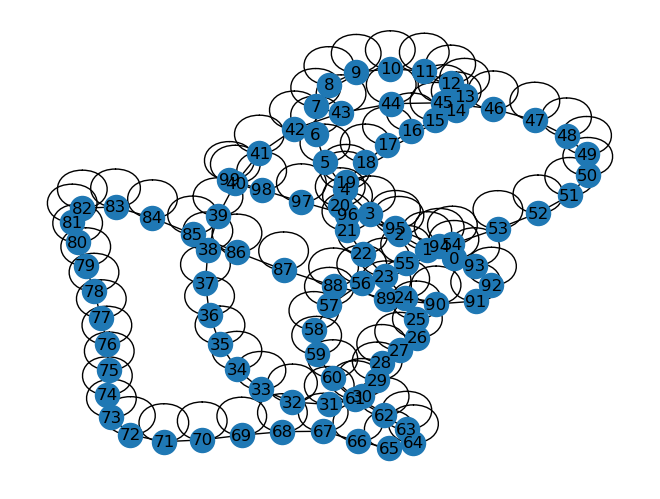

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Run time for UCRL2: 15.812018871307373


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.04it/s]


Run time for Our Algorithm: 6.237498044967651
Total run time: 22.050058126449585


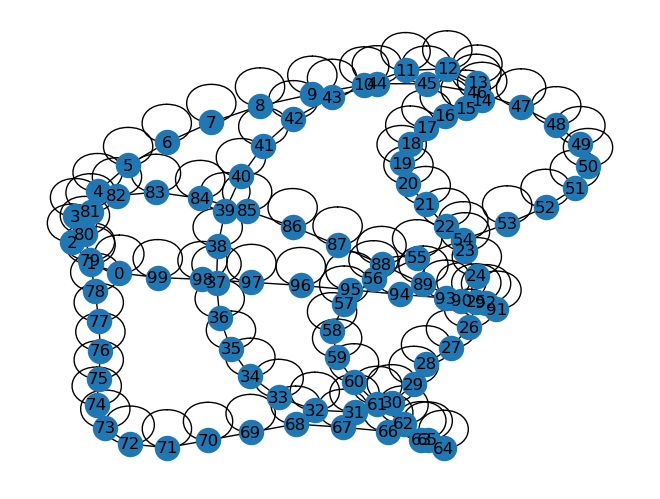

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.94it/s]


Run time for UCRL2: 16.83744192123413


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.02it/s]


Run time for Our Algorithm: 7.679085969924927
Total run time: 24.51680612564087


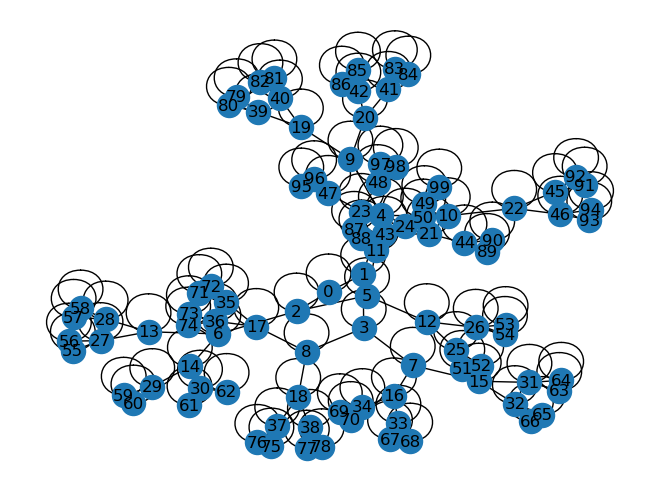

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


Run time for UCRL2: 23.30303406715393


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 40.45it/s]


Run time for Our Algorithm: 2.4730401039123535
Total run time: 25.77632212638855


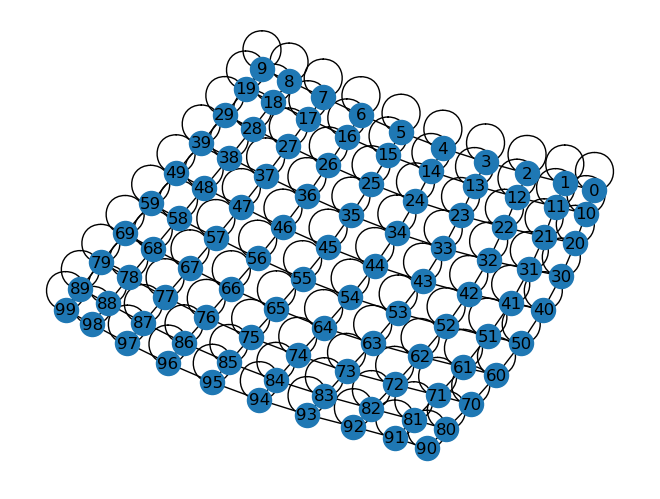

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Run time for UCRL2: 18.69556188583374


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 24.75it/s]


Run time for Our Algorithm: 4.0423290729522705
Total run time: 22.738135814666748


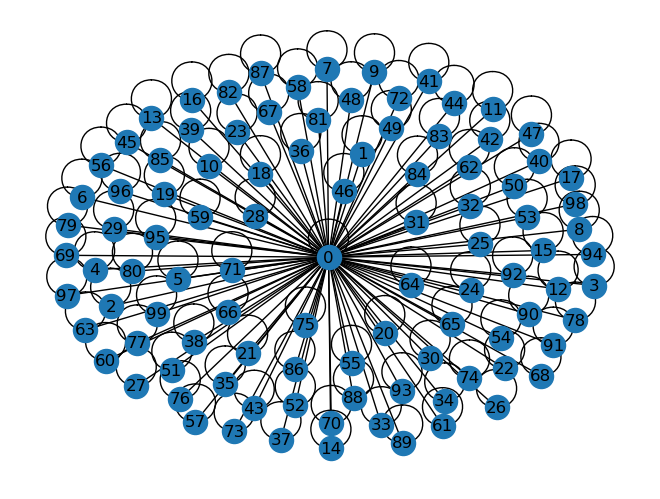

100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


Run time for UCRL2: 31.540056228637695


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 57.15it/s]


Run time for Our Algorithm: 1.750821828842163
Total run time: 33.29112100601196


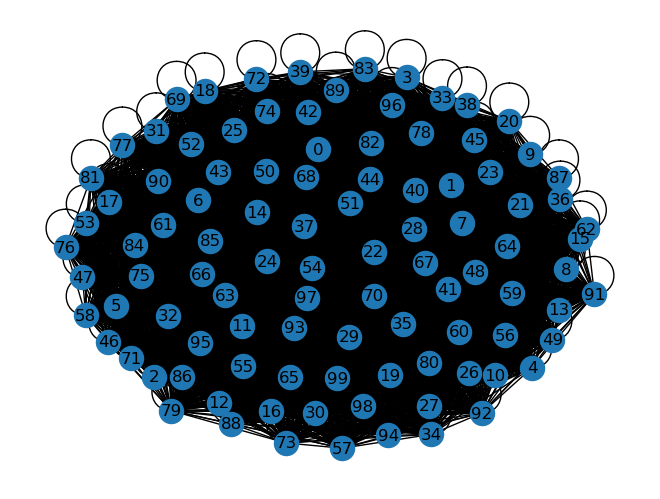

100%|█████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


Run time for UCRL2: 39.616390228271484


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]

Run time for Our Algorithm: 24.97434902191162
Total run time: 64.59101796150208


<Figure size 640x480 with 0 Axes>

In [5]:
graph_types = ['line','circle','tree','grid','star','fully_connected']
# graph_types = ['fully_connected']
T = 1000
n_nodes = 100

times = {g:{} for g in graph_types}
for graph in graph_types:
    np.random.seed(SEED)
    G = return_graph(graph, n_nodes)
    draw_graph(G)

    np.random.seed(SEED)
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    agents = {
         'UCRL2':UCRL2_agent,
         'Our Algorithm':GUCB_agent,
}
    
    t0 = time()
    for name,agent in agents.items():     
        t = time()
        times[graph][name] = time_agent(n_samples,T,G,means, init_node,agent)
        print('Run time for {}:'.format(name),time()-t)

    plt.figure(dpi=100)

    # plotRegrets([line_regrets], titles=['{} Graph'.format(graph)])
    print('Total run time:', time()-t0)

with open('Data/ComputationTime.pkl'.format(graph), 'wb') as file:
    pkl.dump(times,file)
# 

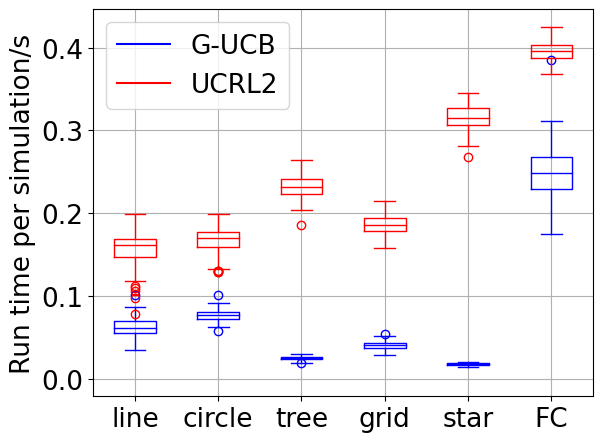

In [7]:
plt.rc('font',size = 19)
labels = graph_types[:-1]
labels.append('FC')

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars


c = 'blue'
plt.boxplot( [times[g]['Our Algorithm'] for g in graph_types], \
            positions = x, widths= width,\
             boxprops=dict(color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c)
           )

cp = 'red'
plt.boxplot( [times[g]['UCRL2'] for g in graph_types], \
            positions = x, widths= width,\
             boxprops=dict(color=cp),
            capprops=dict(color=cp),
            whiskerprops=dict(color=cp),
            flierprops=dict(color=cp, markeredgecolor=cp),
            medianprops=dict(color=cp)
           )

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Run time per simulation/s')
# ax.set_title('Scores by group and gender')
plt.xticks(x, labels)
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
hB, = plt.plot([0,0],c)
hR, = plt.plot([0,0],cp)
plt.grid(True)
plt.legend((hB, hR),('G-UCB', 'UCRL2'))
hB.set_visible(False)
hR.set_visible(False)

plt.tight_layout()
plt.savefig('Figures/Computation/TimeComparison.png')
plt.show()

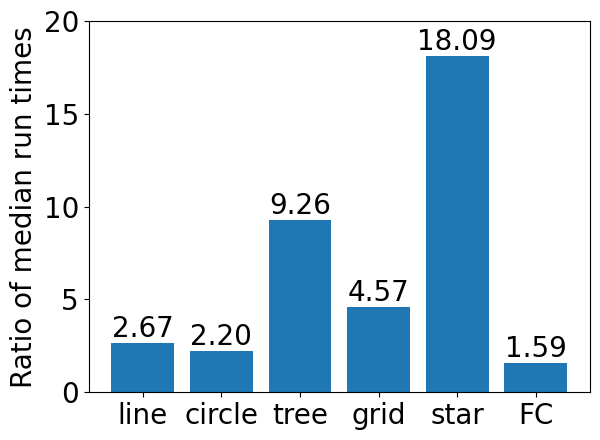

In [29]:
plt.rc('font',size = 20)
b = plt.bar(x,np.array([np.median(times[g]['UCRL2']) for g in graph_types])/np.array([np.median(times[g]['Our Algorithm']) for g in graph_types]))
plt.bar_label(b,fmt='%.2f')
plt.xticks(x,labels)
plt.ylabel('Ratio of median run times')

plt.ylim(0,20)
# plt.grid(True)
plt.tight_layout()

plt.savefig('Figures/Computation/TimeRatio.png')
plt.show()